# House LEGO

In [1]:
using LightGraphs, MetaGraphs
using Catlab, Catlab.WiringDiagrams, Catlab.Graphics

using PyCall # Needed for `PyGraphs` interop.
using CompositionalPlanning, CompositionalPlanning.PyGraphs

function visualize_plan(diagram::WiringDiagram; kw...)
    to_graphviz(diagram; label_attr=:xlabel, direction=:vertical, kw...)
end

cd("../data")

┌ Info: Recompiling stale cache file /Users/canedo/.julia/compiled/v1.1/Catlab/fBQ1G.ji for Catlab [134e5e36-593f-5add-ad60-77f754baafbe]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/canedo/.julia/compiled/v1.1/CompositionalPlanning/ono8m.ji for CompositionalPlanning [37c788b8-b867-11e9-162b-c1e170d75f7d]
└ @ Base loading.jl:1184


## Connectivity graph

Load the connectivity graph for the house LEGO design.

In [2]:
connectivity_graph = read_connectivity_graph("house.graphml")
graph = connectivity_graph.graph

{94, 131} directed simple Int64 graph

Display connectivity graph using Graphviz.

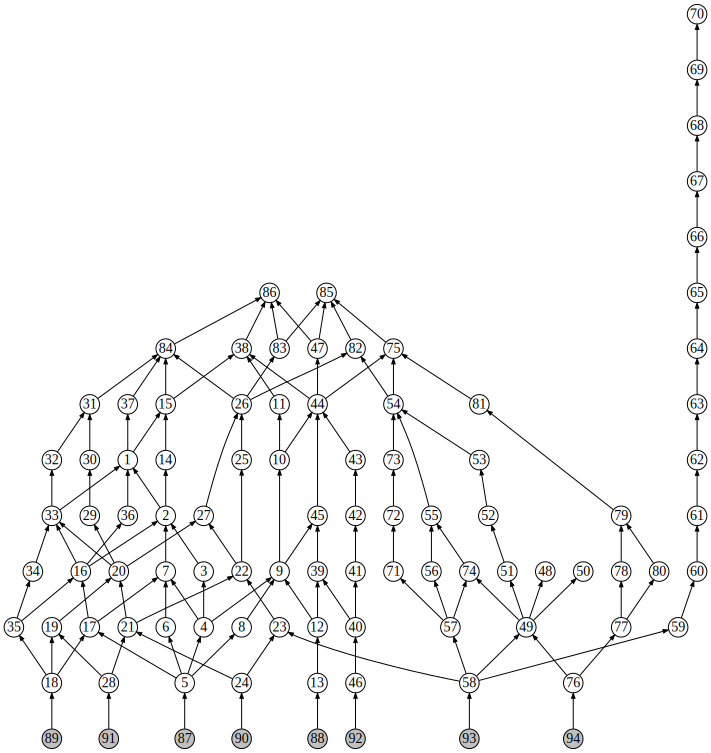

In [3]:
to_graphviz(connectivity_graph_to_dot(connectivity_graph))

## Planning

### Plan #1: Sequential plan

Create a sequential plan from the full connectivity graph.

In [4]:
plan1 = plan = sequential_plan(graph)
write_graphml(plan, "house_sequential_plan.graphml");

Visualize plan without drawing the labels or the incoming or outgoing wires.

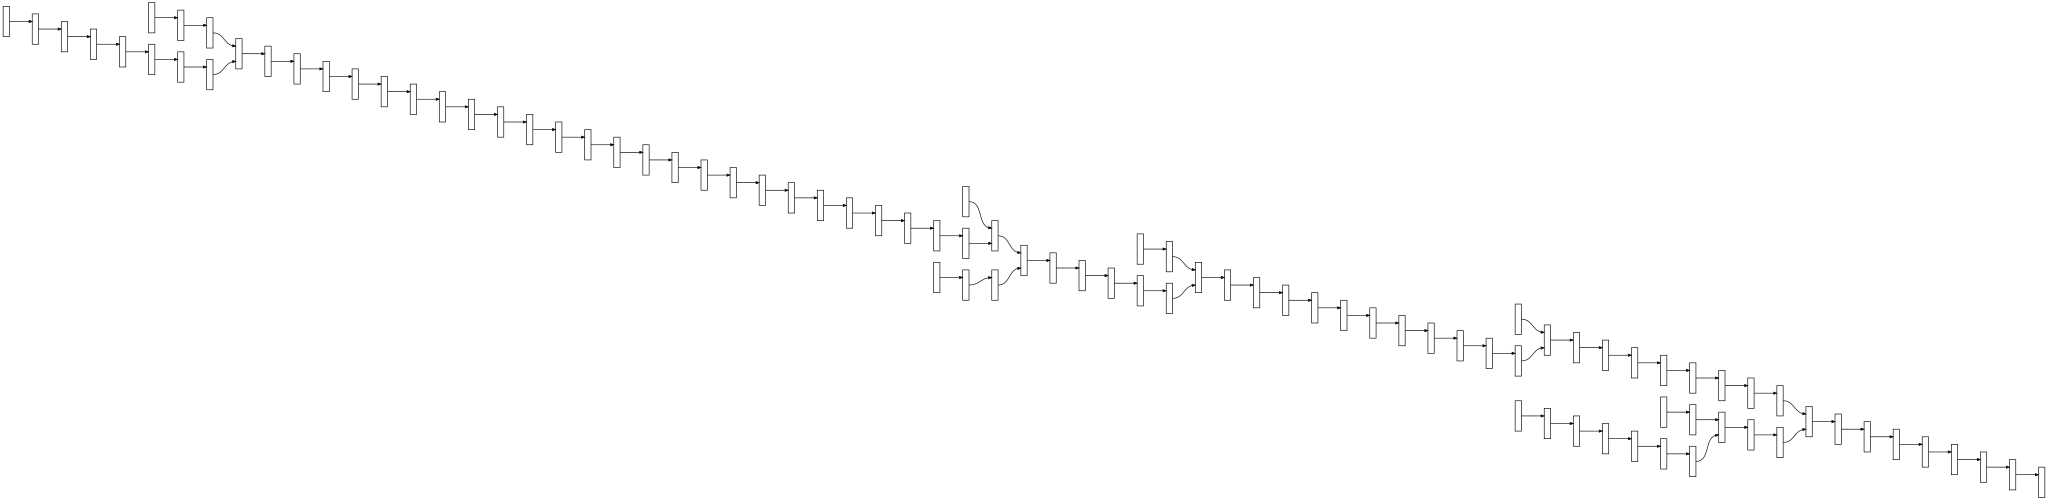

In [5]:
visualize_plan(plan1, labels=false, outer_ports=false, direction=:horizontal)

### Plan #2: Parallel plan using the Leiden algorithm

Find communities using the [Leiden algorithm](https://github.com/vtraag/leidenalg), an improved version of the [Louvain method](https://en.wikipedia.org/wiki/Louvain_modularity).

In [6]:
communities = PyGraphs.cdlib_communities(Graph(graph), :leiden)

8-element Array{Array{Int64,1},1}:
 [8, 9, 10, 11, 12, 13, 38, 39, 40, 41, 42, 43, 44, 45, 46, 88, 92]
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 71, 72, 73, 74, 93]  
 [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 90, 91]          
 [1, 2, 14, 15, 16, 31, 32, 33, 34, 35, 36, 37, 84]                
 [59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]                  
 [3, 4, 5, 6, 7, 17, 18, 87, 89]                                   
 [76, 77, 78, 79, 80, 81, 94]                                      
 [47, 75, 82, 83, 85, 86]                                          

Visualize the communities by setting the node [color](https://www.graphviz.org/doc/info/colors.html) in Graphviz.

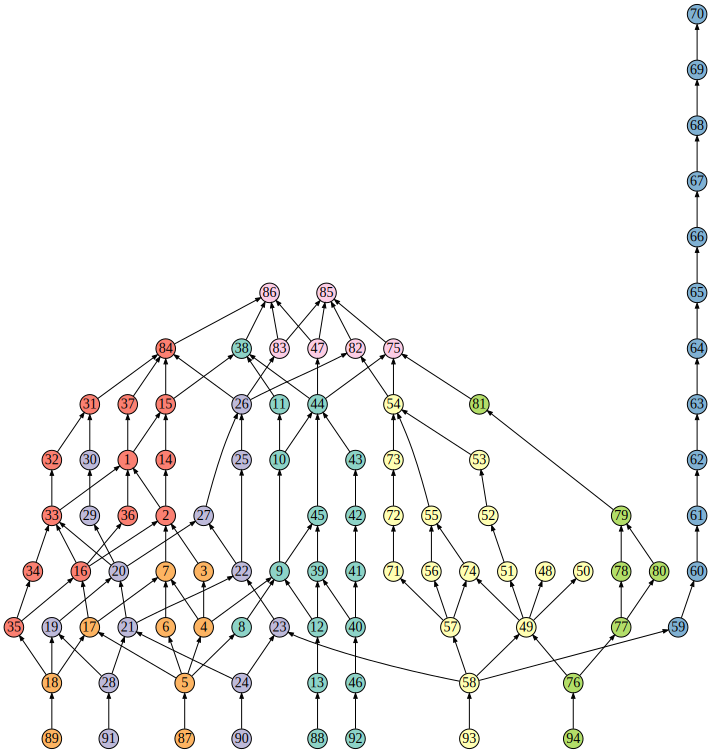

In [7]:
cmap = Dict(v => i for (i,c) in enumerate(communities) for v in c)
dot = connectivity_graph_to_dot(connectivity_graph)
for v in 1:nv(dot)
    set_props!(dot, v, Dict(
        :style => "filled",
        :fillcolor => string("/set38/", cmap[v]),
    ))
end
to_graphviz(dot)

Build a parallel plan using these communities.

In [8]:
plan2 = plan = parallel_plan(graph, communities);
write_graphml(plan, "house_parallel_plan.graphml");

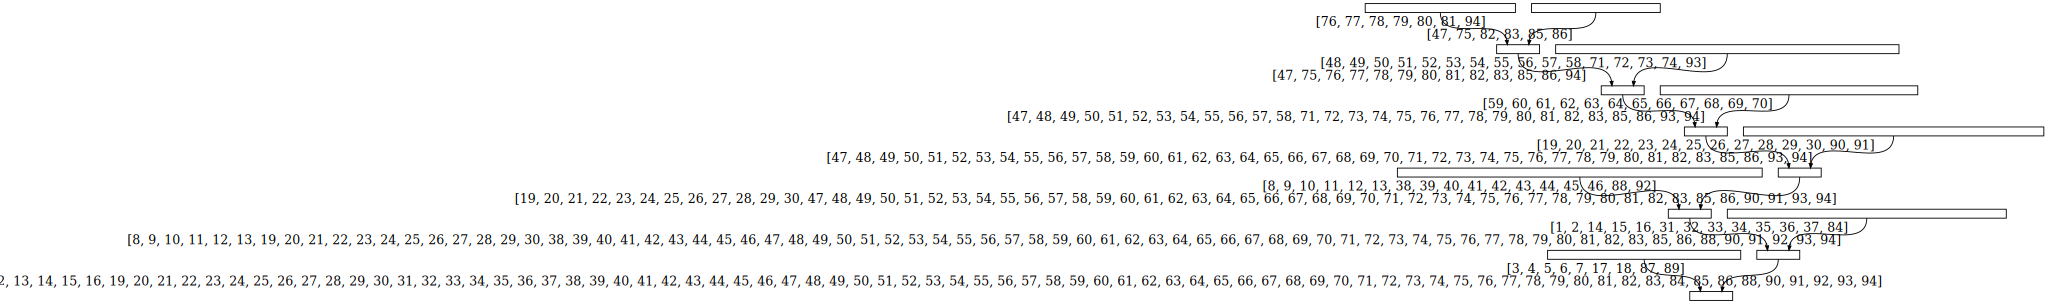

In [9]:
visualize_plan(plan2, labels=true, outer_ports=false, direction=:vertical)

Expand all the sub-plans and generate one big plan.

In [10]:
subplans = filter(v -> box(plan,v) isa WiringDiagram, box_ids(plan))
substitute!(plan, subplans);

## Scheduling

Convert the plans into expressions and then into schedules.

In [11]:
steps1, steps2 = map((plan1, plan2)) do plan
    plan_expr = to_hom_expr(PlanningExpr, plan)
    steps = jsonable_schedule(interleave_hom_expr(plan_expr))
end;

Export the schedules as JSON.

In [12]:
import JSON

open("house_sequential_schedule.json", "w") do io
   JSON.print(io, steps1)
end
open("house_parallel_schedule.json", "w") do io
   JSON.print(io, steps2)
end